In [1]:
import numpy as np
import pandas as pd
import soundfile as sf

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib.patches import Rectangle

import scipy.io.wavfile as wav
import datetime as dt
from pathlib import Path

In [2]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

In [3]:
from src.cfg import get_config
from src.pipeline import pipeline

In [4]:
def subsample(percent_on, audio):
    # Calculate time on for duty cycle using percent on
    time_on = percent_on*audio.shape[0]
    sub_audio = audio[:np.ceil(time_on).astype('int32')]

    return np.arange(time_on), sub_audio.astype('int16')

def plt_msds(filename, audio, fs, reftimes, times, p_on=1):
    ## Make sure given times are within audio file
    #  If times extend beyond file, reduce times to file boundaries
    times[times < 0] = 0
    times[times > len(audio)/fs] = int(len(audio)/fs)
    audio = audio[times[0]*fs:times[1]*fs]

    ## Strip the datetime for year, month, date, and hour from filename
    file_dt = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')

    ## Only find numPoints amount of labels from all available seconds
    numPoints = 11
    seconds = np.arange(fs*times[0], fs*times[1]+1)/fs
    idx = np.round(np.linspace(0, len(seconds)-1, numPoints)).astype('int32')
    sec_labels = reftimes[0] + seconds[idx]

    ## Calculate Time Labels for X-Axis using Datetime objects as Strings
    time_labels = np.array([dt.datetime(year=file_dt.year, month=file_dt.month, 
                                        day=file_dt.day, hour=file_dt.hour, 
                                        minute=file_dt.minute + int(sec/60), second=int(sec%60), 
                                        microsecond=np.round(1e6*(sec%60-int(sec%60))).astype('int32')).strftime('%T.%f')[:-4] 
                                        for sec in sec_labels])

    ## Find x-axis tick locations from all available seconds and convert to samples
    s_ticks = seconds[idx]-times[0]
    x_ticks = s_ticks*fs

    ## Calculate detection parameters from msds output to use for drawing rectangles
    xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels = get_msds_params(filename, reftimes+times)

    ## Create figure
    plt.figure(figsize=(12, 9))

    ## Plotting Audio Signal
    plt.subplot(311)
    plt.title(f"{100*p_on}% Duty Cycle")
    plt.plot(audio)
    plt.ylabel("Amplitude (kU)")
    plt.xlim((0, s_ticks[-1]*fs))
    plt.xticks(ticks=x_ticks, labels=time_labels)
    amp_ticks = plt.yticks()[0]
    amp_ticks = np.insert(amp_ticks, 0, -1*amp_ticks[-1])
    plt.yticks(ticks=amp_ticks, labels=(amp_ticks/1000).astype('int16'))
    plt.ylim((amp_ticks[0], amp_ticks[-1]))
    plt.grid(which="both")

    ## Plotting Spectrogram of Audio Signal
    plt.subplot(312)
    plt.specgram(audio, Fs=fs, cmap='ocean')
    plt.ylabel("Frequency (kHz)")
    plt.xticks(ticks=s_ticks, labels=time_labels)
    ## Find y-axis tick locations from specgram-calculated locations and keep limit just in case
    f_ticks = plt.yticks()[0]
    f_ticks = f_ticks[f_ticks <= fs/2]
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))

    ## Plotting Spectrogram with MSDS outputs overlayed
    plt.subplot(313)
    plt.specgram(audio, Fs=fs, cmap='ocean')
    plt.xlabel("Time (HH:MM:SS)")
    plt.ylabel("Frequency (kHz)")
    plt.xticks(ticks=s_ticks, labels=time_labels)
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))
    ax = plt.gca()
    for i in range(len(xs_inds)):
        rect = Rectangle((xs_inds[i], xs_freqs[i]), 
                        x_durations[i], x_bandwidths[i], 
                        linewidth=1, edgecolor='y', facecolor='none')
        if (np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32') < len(audio) and audio[np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32')] != 0):
            ax.add_patch(rect)
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

def get_msds_params(filename, times):
    csv_file = f'../output_dir/BatDetectorMSDS-{filename}.csv'
    df = pd.read_csv(csv_file)
    s_times = df['start_time']
    e_times = df['end_time']
    s_freqs = df['low_freq']
    e_freqs = df['high_freq']
    det_labels = df['event'].values
    xs_inds = s_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xe_inds = e_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xs_freqs = s_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    xe_freqs = e_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    x_durations = xe_inds - xs_inds
    x_bandwidths = xe_freqs - xs_freqs

    return xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels

In [7]:
## No Subsampling, Raw First 10 min of Audio File

filepath = f"{Path.home()}/Downloads"
filename = "20210910_030000.WAV"

args = dict()
args["input_audio"] = f'{filepath}/{filename}'


In [12]:
track = sf.SoundFile(Path(f'{filepath}/{filename}'))

can_seek = track.seekable() # True
if not can_seek:
    raise ValueError("Not compatible with seeking")

sr = track.samplerate
reftimes = np.array([0, 300])

start_frame = sr * reftimes[0]
frames_to_read = sr * (reftimes[1] - reftimes[0])
track.seek(start_frame)
audio_section = track.read(frames_to_read)

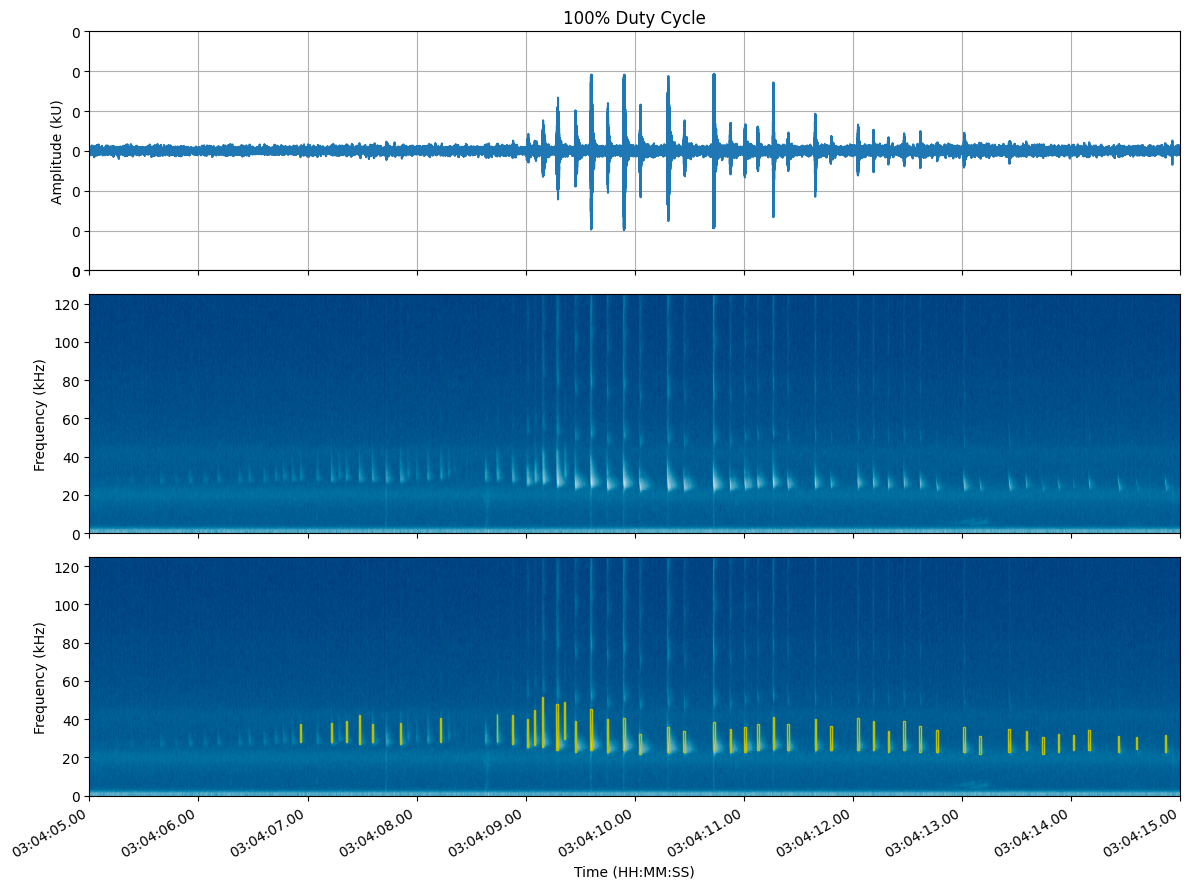

In [14]:
times = np.array([245, 255]) # seconds from beginning of audio

plt_msds(filename, audio_section, sr, reftimes, times)

In [16]:
args["output_directory"] = f'../output_dir/'
args["tmp_directory"] = f'../output/tmp'
args["csv"] = True
args["num_processes"] = 4

cfg = get_config()
cfg["should_csv"] = args["csv"]
cfg["output_dir"] = Path(args["output_directory"])
cfg["tmp_dir"] = Path(args["tmp_directory"])
cfg["audio_file"] = Path(args["input_audio"])
cfg["num_processes"] = args["num_processes"]
print(cfg)

_ = pipeline.run(cfg)

{'time_expansion_factor': 1.0, 'start_time': 0.0, 'segment_duration': 30.0, 'models': [<models.bat_call_detector.model_detector.BatCallDetector object at 0x299b97940>], 'should_csv': True, 'output_dir': PosixPath('../output_dir'), 'tmp_dir': PosixPath('../output/tmp'), 'audio_file': PosixPath('/Users/adityakrishna/Downloads/20210910_032600.WAV'), 'num_processes': 4}


Applying BatDetectorMSDS: 100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


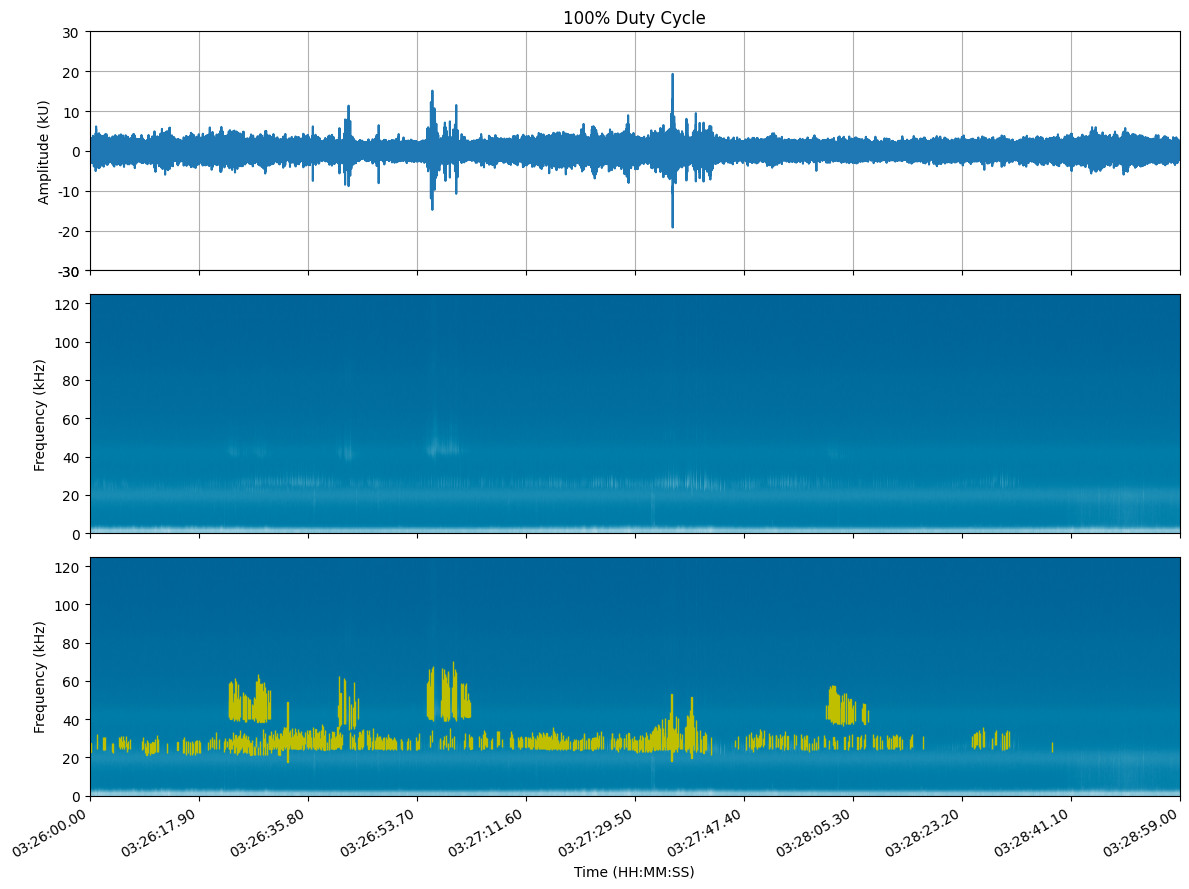

In [13]:
times = np.array([0, 180]) # seconds from beginning of audio

reftimes = np.array([0, 180])
audio1 = audio[reftimes[0]*fs:reftimes[1]*fs]

plt_msds(filename, audio1, fs, reftimes, times)

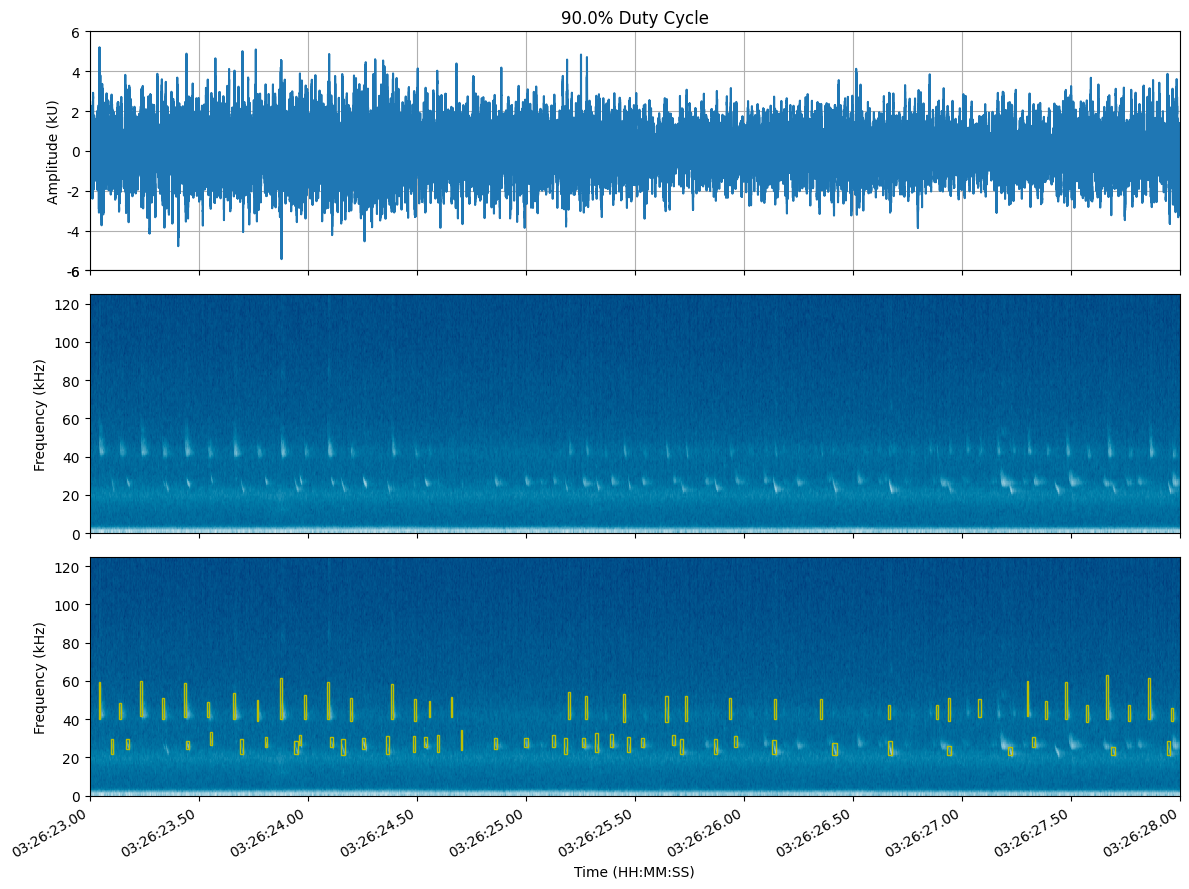

In [15]:
times = np.array([3, 8]) # seconds from beginning of audio

p_on = 0.9
reftimes = np.array([20, 35])

audio1 = audio[reftimes[0]*fs:reftimes[1]*fs]
s2, audio2 = subsample(p_on, audio1)

plt_msds(filename, audio2, fs, reftimes, times, p_on)